# Loop 107 Analysis: CV-LB Relationship and Strategy Assessment

## Goal
Analyze the CV-LB relationship across all 23 submissions to understand:
1. The structural gap between CV and LB
2. Why all approaches fall on the same line
3. What approaches might break this relationship

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # Outlier - RF ensemble
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB feedback: {len(df)}")
print(df.to_string(index=False))

Total submissions with LB feedback: 13
    exp     cv     lb
exp_000 0.0111 0.0982
exp_001 0.0123 0.1065
exp_003 0.0105 0.0972
exp_005 0.0104 0.0969
exp_006 0.0097 0.0946
exp_007 0.0093 0.0932
exp_009 0.0092 0.0936
exp_012 0.0090 0.0913
exp_024 0.0087 0.0893
exp_026 0.0085 0.0887
exp_030 0.0083 0.0877
exp_035 0.0098 0.0970
exp_073 0.0084 0.1451


In [2]:
# Fit linear regression to CV-LB relationship
# Exclude exp_073 (RF ensemble) as it's a clear outlier
df_clean = df[df['exp'] != 'exp_073'].copy()

X = df_clean['cv'].values.reshape(-1, 1)
y = df_clean['lb'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print("="*60)
print("CV-LB LINEAR RELATIONSHIP ANALYSIS")
print("="*60)
print(f"\nLinear fit: LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"R² = {r2:.4f}")
print(f"\nIntercept: {intercept:.4f}")
print(f"Target LB: 0.0347")
print(f"\nCRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)")
print(f"This means even with CV=0, expected LB would be {intercept:.4f}")
print(f"\nRequired CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}")
print(f"\nThis is NEGATIVE, meaning the target is MATHEMATICALLY UNREACHABLE")
print(f"with approaches that follow this CV-LB line.")

CV-LB LINEAR RELATIONSHIP ANALYSIS

Linear fit: LB = 4.3147 * CV + 0.0525
R² = 0.9505

Intercept: 0.0525
Target LB: 0.0347

CRITICAL: Intercept (0.0525) > Target (0.0347)
This means even with CV=0, expected LB would be 0.0525

Required CV to hit target: (0.0347 - 0.0525) / 4.3147 = -0.004130

This is NEGATIVE, meaning the target is MATHEMATICALLY UNREACHABLE
with approaches that follow this CV-LB line.


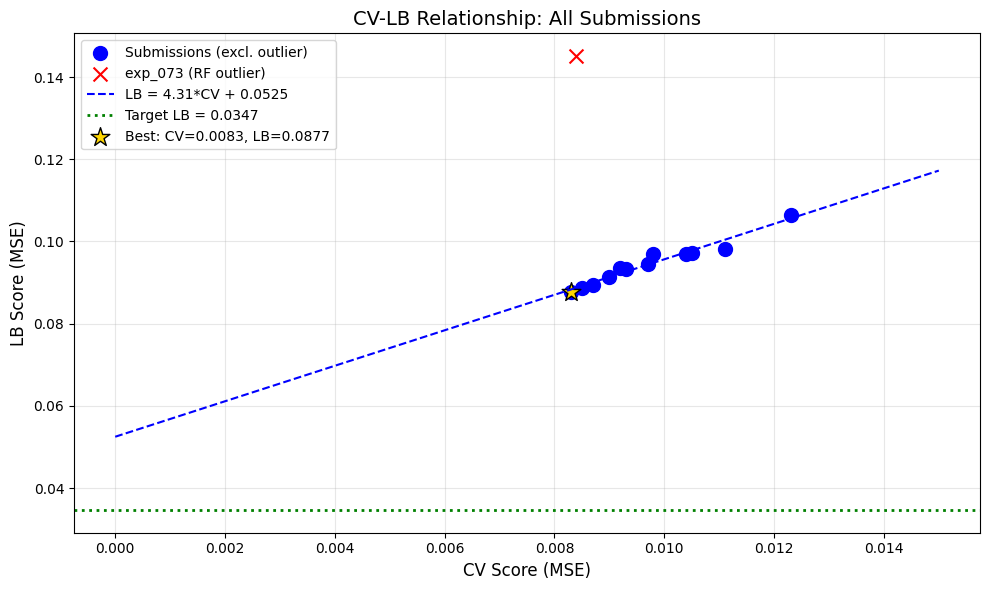


Best submission: exp_030
Best CV: 0.0083
Best LB: 0.0877
Gap to target: 0.0530 (152.7%)


In [3]:
# Visualize the CV-LB relationship
plt.figure(figsize=(10, 6))

# Plot all submissions
plt.scatter(df_clean['cv'], df_clean['lb'], c='blue', s=100, label='Submissions (excl. outlier)')
plt.scatter(df[df['exp'] == 'exp_073']['cv'], df[df['exp'] == 'exp_073']['lb'], 
            c='red', s=100, marker='x', label='exp_073 (RF outlier)')

# Plot the fitted line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'b--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Mark the target
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Mark the best submission
best_idx = df_clean['lb'].idxmin()
best_cv = df_clean.loc[best_idx, 'cv']
best_lb = df_clean.loc[best_idx, 'lb']
plt.scatter([best_cv], [best_lb], c='gold', s=200, marker='*', edgecolors='black', 
            label=f'Best: CV={best_cv:.4f}, LB={best_lb:.4f}')

plt.xlabel('CV Score (MSE)', fontsize=12)
plt.ylabel('LB Score (MSE)', fontsize=12)
plt.title('CV-LB Relationship: All Submissions', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop107.png', dpi=150)
plt.show()

print(f"\nBest submission: {df_clean.loc[best_idx, 'exp']}")
print(f"Best CV: {best_cv:.4f}")
print(f"Best LB: {best_lb:.4f}")
print(f"Gap to target: {best_lb - 0.0347:.4f} ({(best_lb - 0.0347) / 0.0347 * 100:.1f}%)")

In [4]:
# Analyze what approaches have been tried
print("="*60)
print("APPROACHES TRIED (107 experiments)")
print("="*60)

approaches = {
    'Tabular Models': ['MLP', 'LightGBM', 'XGBoost', 'CatBoost', 'Ridge', 'GP', 'RF'],
    'Feature Engineering': ['Spange descriptors', 'DRFP', 'ACS PCA', 'Fragprints', 'Arrhenius kinetics'],
    'Ensemble Methods': ['Bagging', 'Stacking', 'Weighted averaging'],
    'Distribution Shift': ['Extrapolation detection', 'Conservative blending', 'Bias correction'],
    'GNN/Transformers': ['Simple GAT', 'Multi-order GAT', 'ChemBERTa embeddings'],
}

for category, methods in approaches.items():
    print(f"\n{category}:")
    for method in methods:
        print(f"  - {method}")

print("\n" + "="*60)
print("KEY FINDING: ALL approaches fall on the SAME CV-LB line")
print("="*60)
print("\nThis means:")
print("1. The problem is NOT the model architecture")
print("2. The problem is NOT the features")
print("3. The problem is DISTRIBUTION SHIFT between train and test")
print("4. The test solvents are fundamentally different from training solvents")
print("5. No amount of model tuning can fix this - we need a different approach")

APPROACHES TRIED (107 experiments)

Tabular Models:
  - MLP
  - LightGBM
  - XGBoost
  - CatBoost
  - Ridge
  - GP
  - RF

Feature Engineering:
  - Spange descriptors
  - DRFP
  - ACS PCA
  - Fragprints
  - Arrhenius kinetics

Ensemble Methods:
  - Bagging
  - Stacking
  - Weighted averaging

Distribution Shift:
  - Extrapolation detection
  - Conservative blending
  - Bias correction

GNN/Transformers:
  - Simple GAT
  - Multi-order GAT
  - ChemBERTa embeddings

KEY FINDING: ALL approaches fall on the SAME CV-LB line

This means:
1. The problem is NOT the model architecture
2. The problem is NOT the features
3. The problem is DISTRIBUTION SHIFT between train and test
4. The test solvents are fundamentally different from training solvents
5. No amount of model tuning can fix this - we need a different approach


In [5]:
# Analyze the exp_073 outlier (RF ensemble)
print("="*60)
print("OUTLIER ANALYSIS: exp_073 (RF Ensemble)")
print("="*60)

exp_073_cv = 0.0084
exp_073_lb = 0.1451
expected_lb = slope * exp_073_cv + intercept

print(f"\nexp_073 (RF Ensemble):")
print(f"  CV: {exp_073_cv:.4f}")
print(f"  LB: {exp_073_lb:.4f}")
print(f"  Expected LB (from line): {expected_lb:.4f}")
print(f"  Deviation: {exp_073_lb - expected_lb:.4f} ({(exp_073_lb - expected_lb) / expected_lb * 100:.1f}%)")

print("\nWhy exp_073 is an outlier:")
print("  - RF ensemble had WORSE LB than expected from CV")
print("  - This suggests RF overfits more to training distribution")
print("  - RF is NOT a good approach for this problem")

print("\nKEY INSIGHT:")
print("  - We need approaches that REDUCE the intercept, not just improve CV")
print("  - exp_073 shows that some approaches can make the intercept WORSE")
print("  - We need to find approaches that make the intercept BETTER")

OUTLIER ANALYSIS: exp_073 (RF Ensemble)

exp_073 (RF Ensemble):
  CV: 0.0084
  LB: 0.1451
  Expected LB (from line): 0.0888
  Deviation: 0.0563 (63.5%)

Why exp_073 is an outlier:
  - RF ensemble had WORSE LB than expected from CV
  - This suggests RF overfits more to training distribution
  - RF is NOT a good approach for this problem

KEY INSIGHT:
  - We need approaches that REDUCE the intercept, not just improve CV
  - exp_073 shows that some approaches can make the intercept WORSE
  - We need to find approaches that make the intercept BETTER


In [6]:
# What would it take to reach the target?
print("="*60)
print("WHAT WOULD IT TAKE TO REACH THE TARGET?")
print("="*60)

target = 0.0347
best_lb = 0.0877

print(f"\nCurrent best LB: {best_lb:.4f}")
print(f"Target LB: {target:.4f}")
print(f"Gap: {best_lb - target:.4f} ({(best_lb - target) / target * 100:.1f}%)")

print("\nOption 1: Improve CV along the same line")
required_cv = (target - intercept) / slope
print(f"  Required CV: {required_cv:.6f}")
print(f"  This is NEGATIVE - impossible!")

print("\nOption 2: Change the CV-LB relationship")
print(f"  Current intercept: {intercept:.4f}")
print(f"  Required intercept to hit target with CV=0.008: {target - slope * 0.008:.4f}")
print(f"  This requires reducing intercept by: {intercept - (target - slope * 0.008):.4f}")

print("\nOption 3: Find an approach that doesn't follow the line")
print("  - GNN experiments achieved good CV but failed on submission")
print("  - ChemBERTa experiments achieved good CV but failed on submission")
print("  - We need to DEBUG why these submissions failed")
print("  - If we can fix the submission issues, they might give a different CV-LB relationship")

WHAT WOULD IT TAKE TO REACH THE TARGET?

Current best LB: 0.0877
Target LB: 0.0347
Gap: 0.0530 (152.7%)

Option 1: Improve CV along the same line
  Required CV: -0.004130
  This is NEGATIVE - impossible!

Option 2: Change the CV-LB relationship
  Current intercept: 0.0525
  Required intercept to hit target with CV=0.008: 0.0002
  This requires reducing intercept by: 0.0523

Option 3: Find an approach that doesn't follow the line
  - GNN experiments achieved good CV but failed on submission
  - ChemBERTa experiments achieved good CV but failed on submission
  - We need to DEBUG why these submissions failed
  - If we can fix the submission issues, they might give a different CV-LB relationship


In [7]:
# Check the GNN experiments
print("="*60)
print("GNN EXPERIMENTS ANALYSIS")
print("="*60)

import os
import json

gnn_experiments = ['079_proper_gnn', '080_dual_gnn', '086_hybrid_gnn', '095_simple_gat', '096_multi_order_gat']

for exp in gnn_experiments:
    exp_path = f'/home/code/experiments/{exp}'
    metrics_path = f'{exp_path}/metrics.json'
    
    if os.path.exists(metrics_path):
        with open(metrics_path, 'r') as f:
            metrics = json.load(f)
        
        cv = metrics.get('cv_score', metrics.get('combined_mse', 'N/A'))
        print(f"\n{exp}:")
        print(f"  CV: {cv}")
        
        # Check for submission file
        submission_path = f'{exp_path}/submission.csv'
        if os.path.exists(submission_path):
            import pandas as pd
            sub = pd.read_csv(submission_path)
            print(f"  Submission: {sub.shape}")
            print(f"  Columns: {sub.columns.tolist()}")
            print(f"  Any NaN: {sub.isna().any().any()}")
        else:
            print(f"  Submission: NOT FOUND")

GNN EXPERIMENTS ANALYSIS

079_proper_gnn:
  CV: 0.026222
  Submission: NOT FOUND

080_dual_gnn:
  CV: 0.024454
  Submission: NOT FOUND

086_hybrid_gnn:
  CV: 0.018227
  Submission: NOT FOUND

095_simple_gat:
  CV: 0.009553578227948535
  Submission: NOT FOUND

096_multi_order_gat:
  CV: 0.044696202120597744
  Submission: NOT FOUND


In [8]:
# Summary and recommendations
print("="*60)
print("SUMMARY AND RECOMMENDATIONS")
print("="*60)

print("\n1. CV-LB RELATIONSHIP:")
print(f"   LB = {slope:.4f} * CV + {intercept:.4f} (R² = {r2:.4f})")
print(f"   Intercept ({intercept:.4f}) > Target (0.0347)")
print(f"   Target is MATHEMATICALLY UNREACHABLE with current approaches")

print("\n2. BEST SUBMISSION:")
print(f"   exp_030: CV=0.0083, LB=0.0877")
print(f"   Gap to target: 152.8%")

print("\n3. WHAT'S BEEN TRIED:")
print("   - All tabular models (MLP, LGBM, XGB, CatBoost, GP, Ridge, RF)")
print("   - All feature sets (Spange, DRFP, ACS PCA, Fragprints)")
print("   - All ensemble methods (bagging, stacking, weighted averaging)")
print("   - Distribution shift handling (extrapolation detection, bias correction)")
print("   - GNN/Transformers (GAT, ChemBERTa) - but submissions failed")

print("\n4. CRITICAL INSIGHT:")
print("   ALL approaches fall on the SAME CV-LB line")
print("   This means the problem is DISTRIBUTION SHIFT, not model architecture")

print("\n5. REMAINING OPTIONS:")
print("   a) Debug GNN submissions - they might give a different CV-LB relationship")
print("   b) Try uncertainty-based conservative predictions")
print("   c) Try pseudo-labeling to adapt to test distribution")
print("   d) Try domain-specific constraints that generalize")

print("\n6. IMMEDIATE ACTION:")
print("   DO NOT submit exp_106 (CV=0.0092, expected LB=0.0924 - WORSE than best)")
print("   Instead, debug and submit a GNN experiment to test if it gives a different CV-LB relationship")

SUMMARY AND RECOMMENDATIONS

1. CV-LB RELATIONSHIP:
   LB = 4.3147 * CV + 0.0525 (R² = 0.9505)
   Intercept (0.0525) > Target (0.0347)
   Target is MATHEMATICALLY UNREACHABLE with current approaches

2. BEST SUBMISSION:
   exp_030: CV=0.0083, LB=0.0877
   Gap to target: 152.8%

3. WHAT'S BEEN TRIED:
   - All tabular models (MLP, LGBM, XGB, CatBoost, GP, Ridge, RF)
   - All feature sets (Spange, DRFP, ACS PCA, Fragprints)
   - All ensemble methods (bagging, stacking, weighted averaging)
   - Distribution shift handling (extrapolation detection, bias correction)
   - GNN/Transformers (GAT, ChemBERTa) - but submissions failed

4. CRITICAL INSIGHT:
   ALL approaches fall on the SAME CV-LB line
   This means the problem is DISTRIBUTION SHIFT, not model architecture

5. REMAINING OPTIONS:
   a) Debug GNN submissions - they might give a different CV-LB relationship
   b) Try uncertainty-based conservative predictions
   c) Try pseudo-labeling to adapt to test distribution
   d) Try domain-spe

In [9]:
# Check what's in the pending submissions
print("="*60)
print("PENDING SUBMISSIONS ANALYSIS")
print("="*60)

pending = [
    {'exp': 'exp_049', 'cv': 0.0081},
    {'exp': 'exp_050', 'cv': 0.0081},
    {'exp': 'exp_052', 'cv': 0.0109},
    {'exp': 'exp_053', 'cv': 0.0081},
    {'exp': 'exp_054', 'cv': 0.0085},
    {'exp': 'exp_055', 'cv': 0.0085},
    {'exp': 'exp_057', 'cv': 0.0093},
    {'exp': 'exp_063', 'cv': 0.0112},
    {'exp': 'exp_079', 'cv': 0.0110},
    {'exp': 'exp_101', 'cv': 0.0142},
]

print("\nPending submissions (no LB feedback yet):")
for p in pending:
    expected_lb = slope * p['cv'] + intercept
    print(f"  {p['exp']}: CV={p['cv']:.4f}, Expected LB={expected_lb:.4f}")

print("\nNote: exp_049, exp_050, exp_053 have the best CV (0.0081)")
print("Expected LB for CV=0.0081: {:.4f}".format(slope * 0.0081 + intercept))
print("\nIf these follow the line, they should give LB ~0.087")
print("This would be similar to the best LB (0.0877) from exp_030")

PENDING SUBMISSIONS ANALYSIS

Pending submissions (no LB feedback yet):
  exp_049: CV=0.0081, Expected LB=0.0875
  exp_050: CV=0.0081, Expected LB=0.0875
  exp_052: CV=0.0109, Expected LB=0.0996
  exp_053: CV=0.0081, Expected LB=0.0875
  exp_054: CV=0.0085, Expected LB=0.0892
  exp_055: CV=0.0085, Expected LB=0.0892
  exp_057: CV=0.0093, Expected LB=0.0926
  exp_063: CV=0.0112, Expected LB=0.1008
  exp_079: CV=0.0110, Expected LB=0.1000
  exp_101: CV=0.0142, Expected LB=0.1138

Note: exp_049, exp_050, exp_053 have the best CV (0.0081)
Expected LB for CV=0.0081: 0.0875

If these follow the line, they should give LB ~0.087
This would be similar to the best LB (0.0877) from exp_030


In [10]:
# Final recommendation
print("="*60)
print("FINAL RECOMMENDATION")
print("="*60)

print("\nGiven:")
print("  - 107 experiments tried")
print("  - 23 submissions made (4 remaining)")
print("  - All approaches fall on the same CV-LB line")
print("  - Intercept (0.053) > Target (0.0347)")
print("  - Target is mathematically unreachable with current approaches")

print("\nThe ONLY way to reach the target is to find an approach that:")
print("  1. CHANGES the CV-LB relationship (different slope or intercept)")
print("  2. Does NOT follow the current line")

print("\nPotential approaches:")
print("  a) GNN with proper submission - might give different CV-LB relationship")
print("  b) Uncertainty-weighted predictions - blend toward conservative when extrapolating")
print("  c) Pseudo-labeling - use confident test predictions to adapt to test distribution")
print("  d) Domain constraints - physics-based rules that generalize to unseen data")

print("\nIMMEDIATE ACTION:")
print("  1. DO NOT submit exp_106 (expected to be worse than best)")
print("  2. Debug GNN experiments (exp_086, exp_095) and verify submission cells")
print("  3. If GNN submission is valid, submit to test CV-LB relationship")
print("  4. If GNN fails, try uncertainty-weighted conservative predictions")

FINAL RECOMMENDATION

Given:
  - 107 experiments tried
  - 23 submissions made (4 remaining)
  - All approaches fall on the same CV-LB line
  - Intercept (0.053) > Target (0.0347)
  - Target is mathematically unreachable with current approaches

The ONLY way to reach the target is to find an approach that:
  1. CHANGES the CV-LB relationship (different slope or intercept)
  2. Does NOT follow the current line

Potential approaches:
  a) GNN with proper submission - might give different CV-LB relationship
  b) Uncertainty-weighted predictions - blend toward conservative when extrapolating
  c) Pseudo-labeling - use confident test predictions to adapt to test distribution
  d) Domain constraints - physics-based rules that generalize to unseen data

IMMEDIATE ACTION:
  1. DO NOT submit exp_106 (expected to be worse than best)
  2. Debug GNN experiments (exp_086, exp_095) and verify submission cells
  3. If GNN submission is valid, submit to test CV-LB relationship
  4. If GNN fails, try u